# Part II: Profiling individual users through Time Series Analysis of Gym Logins

Now we turn to a different task. As opposed to the ensemble statistics, which exhibited clear structure and which could be modeled very well with all the methods discussed earlier, we now investigate whether there is also structure in the individual users. 

In [17]:
import pandas as pd 
import numpy as np
import time 

import matplotlib.pyplot as plt                  # plots

import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions

from tqdm import tqdm_notebook

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First off, we import the sanitized dataset.

In [2]:
#passing a list of datatypes for the columns
login_dtypes = {"ID": int, "RES_ID": int, "DATE_SAVED": str, "DATE_LAST_MODIFIED": str, "CUST_CODE": str, 
            "IS_ARRIVED": str, "LOCATION": int, "COMPUTED_RSV_ID": str}

#columns that are given as dates can be parsed while reading 
login_date_columns = ['DATE_SAVED', 'DATE_LAST_MODIFIED']

login_data_sanitized = pd.read_csv("login_data_sanitized.csv", dtype=login_dtypes, parse_dates=login_date_columns)

In [3]:
#Sets the ID as the index of login_data_sanitized. 
#Running twice will result in a KeyError exception
login_data_sanitized = login_data_sanitized.set_index("ID")

In [4]:
login_sample = login_data_sanitized.iloc[0]

login_sample

RES_ID                              50521
DATE_SAVED            2013-04-16 10:47:58
DATE_LAST_MODIFIED    2013-04-16 10:47:58
CUST_CODE                         2079.10
IS_ARRIVED                              T
LOCATION                               10
COMPUTED_RSV_ID                   1051742
DATE                           2013-04-16
MONTH                                   4
WEEK                                   16
DAYOFWEEK                               1
Name: 51742, dtype: object

In [9]:
login_data_sanitized

,RES_ID,DATE_SAVED,DATE_LAST_MODIFIED,CUST_CODE,IS_ARRIVED,LOCATION,COMPUTED_RSV_ID,DATE,MONTH,WEEK,DAYOFWEEK
ID,,,,,,,,,,,
51742,50521,2013-04-16 10:47:58,2013-04-16 10:47:58,2079.10,T,10,1051742,2013-04-16,4,16,1
51743,50541,2013-04-16 11:39:41,2013-04-16 11:39:41,4032.10,T,10,1051743,2013-04-16,4,16,1
52517,49331,2013-04-16 14:25:41,2013-04-16 14:25:41,8002122.80,T,80,8052517,2013-04-16,4,16,1
52518,50581,2013-04-16 14:25:57,2013-04-16 14:25:57,2649.10,T,10,1052518,2013-04-16,4,16,1
52519,50561,2013-04-16 14:26:11,2013-04-16 14:26:11,2649.10,T,10,1052519,2013-04-16,4,16,1
52520,51993,2013-04-16 14:28:43,2013-04-16 14:28:43,4001173.50,T,50,5052520,2013-04-16,4,16,1
52521,51993,2013-04-16 14:28:50,2013-04-16 14:28:50,4001177.50,T,50,5052521,2013-04-16,4,16,1
52522,50601,2013-04-16 14:30:38,2013-04-16 14:30:38,2649.10,T,10,1052522,2013-04-16,4,16,1
52523,49331,2013-04-16 14:32:15,2013-04-16 14:32:15,8000958.80,T,80,8052523,2013-04-16,4,16,1


In [6]:
login_counts = login_data_sanitized["CUST_CODE"].value_counts()

login_counts[login_counts == 1].index

Index(['3007123.40', '2701733.39', '3007539.40', '2152386.29', '2102453.28',
       '2601189.38', '14003557.4', '13003755.3', '72576.19', '7002160.70',
       ...
       '51600.11', '2351986.33', '2152028.29', '13002442.3', '4001409.50',
       '2500290.36', '2452672.35', '3000943.40', '2700349.39', '2004053.30'],
      dtype='object', length=6467)

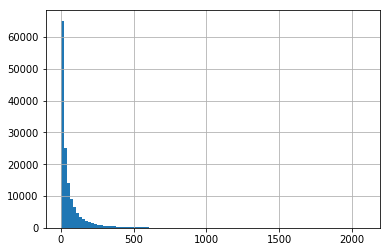

In [7]:
login_counts.hist(bins=100)

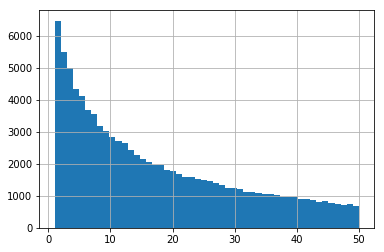

In [8]:
login_counts[login_counts <= 50].hist(bins=50)
plt.savefig("login_hist.jpg", my_dpi=300)

We see that the login distribution is a translated exponential distribution. It seems to drop off rather quickly, i.e. with a large parameter $\lambda$.

To find the applicable date range for logins in a customer's visit history, we also import the sanitized customer base.

In [10]:
#passing a list of datatypes for the columns of customer base
customer_dtypes = {'ISACTIVE': str, "CUST_CODE": str, 'CLASS_CODE': str, 'BUSINESS_CODE': str, 'SEX': str, 'NO_MAIL': str, 
                   'NO_SMS': str, 'COMPANY_CUST_CODE': str, 'IS_DROP_IN_CUSTOMER': str}

#list of columns that will be parsed as dates
customer_date_cols = ['EXPIRE_DATE', 'LAST_VISIT', 'DATE_SAVED', 'DATE_LAST_MODIFIED', 'RENEW_DATE', 'PAUSE_START', 'PAUSE_END', 'MEMBER_SINCE']

#first row in RES_CARD.xlsx is a nonsense entry, so skip it. HEADER COUNTS --> FIRST ROW HAS INDEX 1
rows_to_skip = [1]

customer_base = pd.read_csv('sanitized_customer_base.csv', skiprows=rows_to_skip, dtype=customer_dtypes, parse_dates=customer_date_cols, index_col=0)

In [11]:
customer_bool_cols = ['ISACTIVE', 'NO_SMS', 'NO_MAIL', 'IS_DROP_IN_CUSTOMER']

#dict object mapping the boolean columns 
bool_converter = {'T': True, 'F': False}

#convert boolean columns to bools 
for col in customer_bool_cols:
    customer_base[col] = customer_base[col].map(bool_converter) 

In [12]:
customer_base

,ISACTIVE,EXPIRE_DATE,LAST_VISIT,CLASS_CODE,DATE_SAVED,DATE_LAST_MODIFIED,RENEW_DATE,PAUSE_START,PAUSE_END,BUSINESS_CODE,SEX,NO_MAIL,NO_SMS,MEMBER_SINCE,COMPANY_CUST_CODE,IS_DROP_IN_CUSTOMER,CONTRACT_DURATION,ACTIVE_DURATION
CUST_CODE,,,,,,,,,,,,,,,,,,
4766.10,False,2013-05-19,2013-04-16,10.10,2013-04-16 10:03:17,2014-06-11 12:02:14,1899-12-30,1899-12-30,1899-12-30,10.10,F,False,False,2012-11-20 00:00:00,NaN,False,180 days 00:00:00.000000000,147 days 00:00:00.000000000
4674.10,False,2013-09-30,2013-04-16,10.10,2013-04-16 10:03:19,2014-06-11 12:02:15,1899-12-30,1899-12-30,1899-12-30,10.10,F,False,False,2012-11-01 00:00:00,NaN,False,333 days 00:00:00.000000000,166 days 00:00:00.000000000
9000130.90,False,2013-07-25,2013-04-16,10.90,2013-04-16 11:24:11,2013-09-26 16:18:43,1899-12-30,1899-12-30,1899-12-30,10.90,NaN,False,False,2012-09-18 00:00:00,NaN,False,310 days 00:00:00.000000000,210 days 00:00:00.000000000
2002108.30,False,2013-04-21,2013-04-16,10.30,2013-04-16 11:55:51,2014-09-22 15:02:53,1899-12-30,1899-12-30,1899-12-30,10.30,F,False,False,2012-11-21 00:00:00,NaN,False,151 days 00:00:00.000000000,146 days 00:00:00.000000000
2001597.30,False,2013-12-04,2013-04-16,10.30,2013-04-16 11:56:02,2015-10-08 11:06:09,1899-12-30,1899-12-30,1899-12-30,10.30,F,False,False,2012-06-04 00:00:00,NaN,False,548 days 00:00:00.000000000,316 days 00:00:00.000000000
8001846.80,False,2013-05-09,2013-04-16,10.80,2013-04-16 13:16:35,2015-08-18 13:08:28,1899-12-30,1899-12-30,1899-12-30,10.80,F,False,False,2013-02-10 00:00:00,.80,False,88 days 00:00:00.000000000,65 days 00:00:00.000000000
8001622.80,False,2013-08-14,2013-04-16,10.80,2013-04-16 13:16:41,2013-09-26 18:01:48,1899-12-30,1899-12-30,1899-12-30,10.80,F,False,False,2013-01-14 00:00:00,NaN,False,212 days 00:00:00.000000000,92 days 00:00:00.000000000
11000153.1,False,2013-06-13,2013-04-16,10.1,2013-04-16 15:47:40,2014-01-16 09:01:38,NaT,NaT,NaT,10.1,M,False,False,2013-02-08 00:00:00,NaN,False,125 days 00:00:00.000000000,67 days 00:00:00.000000000
4901.10,False,2013-05-05,2013-04-17,10.10,2013-04-16 10:03:14,2014-06-11 12:02:12,1899-12-30,1899-12-30,1899-12-30,10.10,F,False,False,2013-01-06 00:00:00,NaN,False,119 days 00:00:00.000000000,101 days 00:00:00.000000000


In [13]:
#example time series using the below customer code
ex_cust_code = "8000938.80"

ex_data = login_data_sanitized[login_data_sanitized["CUST_CODE"] == ex_cust_code]

ex_data

,RES_ID,DATE_SAVED,DATE_LAST_MODIFIED,CUST_CODE,IS_ARRIVED,LOCATION,COMPUTED_RSV_ID,DATE,MONTH,WEEK,DAYOFWEEK
ID,,,,,,,,,,,
229141,49169,2013-07-01 17:00:31,2013-07-01 17:00:31,8000938.80,T,80,80229141,2013-07-01,7,27,0
233417,49515,2013-07-03 10:49:07,2013-07-03 10:49:07,8000938.80,T,80,80233417,2013-07-03,7,27,2
234176,148323,2013-07-04 11:04:14,2013-07-04 11:04:14,8000938.80,T,80,80234176,2013-07-04,7,27,3
234179,49688,2013-07-04 11:04:19,2013-07-04 11:04:19,8000938.80,T,80,80234179,2013-07-04,7,27,3
245527,49689,2013-07-11 06:13:55,2013-07-11 06:13:55,8000938.80,T,80,80245527,2013-07-11,7,28,3
254142,49344,2013-07-16 10:21:49,2013-07-16 10:21:49,8000938.80,T,80,80254142,2013-07-16,7,29,1
258484,49690,2013-07-18 12:35:47,2013-07-18 12:35:47,8000938.80,T,80,80258484,2013-07-18,7,29,3
263050,48999,2013-07-21 11:10:08,2013-07-21 11:10:08,8000938.80,T,80,80263050,2013-07-21,7,29,6
277778,49346,2013-07-30 10:30:11,2013-07-30 10:30:11,8000938.80,T,80,80277778,2013-07-30,7,31,1


In [14]:
#get data about the example customer
example_customer = customer_base.loc[ex_cust_code]

example_customer

ISACTIVE                                        True
EXPIRE_DATE                      2100-12-31 00:00:00
LAST_VISIT                       2018-09-13 00:00:00
CLASS_CODE                                     20.80
DATE_SAVED                       2013-07-01 17:58:44
DATE_LAST_MODIFIED               2018-09-13 09:45:47
RENEW_DATE                                       NaT
PAUSE_START                                      NaT
PAUSE_END                                        NaT
BUSINESS_CODE                                  10.80
SEX                                                F
NO_MAIL                                        False
NO_SMS                                         False
MEMBER_SINCE                     2012-10-07 00:00:00
COMPANY_CUST_CODE                                NaN
IS_DROP_IN_CUSTOMER                            False
CONTRACT_DURATION      32226 days 00:00:00.000000000
ACTIVE_DURATION         2167 days 00:00:00.000000000
Name: 8000938.80, dtype: object

In [15]:
example_visiting_dates = pd.DatetimeIndex([d.date() for d in ex_data.DATE_SAVED])

example_visiting_dates

DatetimeIndex(['2013-07-01', '2013-07-03', '2013-07-04', '2013-07-04',
               '2013-07-11', '2013-07-16', '2013-07-18', '2013-07-21',
               '2013-07-30', '2013-07-31',
               ...
               '2018-08-27', '2018-08-30', '2018-08-31', '2018-09-02',
               '2018-09-03', '2018-09-05', '2018-09-06', '2018-09-10',
               '2018-09-11', '2018-09-13'],
              dtype='datetime64[ns]', length=377, freq=None)

We plotted each day in between the first visit and the last as zeros or ones, depending on whether the customer went to the gym or not. We will now abstract this logic into a function.

In [31]:
def construct_binary_visit_series(customer_codes, customer_database, login_database, return_densities=False):
    """
    Method that constructs binary visit time series for a list of customer codes (each uniquely identifying a user).
    
    Parameters:
    cust_codes(list): List of customer codes. Will be checked against customer_database and login_database, 
    so should correspond to a customer that is present in both dataframes
    
    customer_database (pd.DataFrame): Dataframe holding the customer database.
    
    login_database (pd.DataFrame): Dataframe holding the login_data that will be extracted.
    
    return_densities (list): Whether or not to return densities of the compressed binary time series. 
    These can be interpreted as an average amount of visits per day, so 1 / sparsity grade is the average length between visits for the given user.
    
    Returns:
    A list of pd.Series in sparse format, with entries of 1 when a customer visits the gym for each day 
    in his active duration (see below) and 0 otherwise. 
    
    If return_densities is set to True, also returns the density of the binary timeseries.
    """
    #list that will hold user time series
    cust_visit_series = []
    cust_series_densities = []
    
    for cust_code in customer_codes:
        try:
            #get information about the customer
            customer_data = customer_database.loc[cust_code]
            
            #extract all logins of the customer from the database
            customer_logins = login_database[login_database["CUST_CODE"] == cust_code]
            
            #get the visiting dates from the logins
            visiting_dates = pd.DatetimeIndex([d.date() for d in customer_logins.DATE_SAVED])

            active_range = pd.date_range(start=visiting_dates[0], end=visiting_dates[-1])
            
            #construct the binary timeseries by checking on which of the dates in the active 
            #time frame the customer went to the gym
            
            cust_timeseries = pd.Series(pd.SparseArray(active_range.isin(visiting_dates).astype(int)), index=active_range)

            cust_visit_series.append(cust_timeseries)
            
            cust_series_densities.append(cust_timeseries.sparse.density)
            
        except KeyError:
            continue
    
    if return_densities:
        return cust_visit_series, cust_series_densities
    
    return cust_visit_series
        

To be able to work in time and frequency space, we will also define a function that gives an array of time differences between logins.

In [19]:
def get_timedeltas(login_timestamps, return_float_times=False):
    
    """
    Helper function that returns the time differences (delta t's) between consecutive logins for a user.
    We just input the datetime stamps as an index, hence this method will also work when called on a DataFrame of 
    customer logins.
    
    Parameters: 
    
    login_timestamps (pd.Index): DatetimeIndex from a series or dataframe with user logins. Can be used on both binary
    timeseries as returned by the method construct_binary_visit_series (see above) or from the DataFrame holding the 
    logins directly.
    
    return_float_times (bool): Whether or not to return the times as timedifferences (pd.Timedelta objects) or floats.
    
    Returns: 
    times_between_logins (list of objects): List of time differences, either in pd.Timedelta format or as floats.
    
    """
    if len(login_timestamps) == 1:
        raise ValueError("Error: For computing time differences, the user must have more than one registered login")
    
    #get the dates on which the customer visited the gym
    
    timedeltas = login_timestamps.to_series().diff()
    
    #realign the series so that a value on a given date represents the time in days until the next visit
    timedeltas.shift(-1)
    
    if return_float_times:
        timedeltas = timedeltas / pd.Timedelta(days=1)
        
    return timedeltas
    

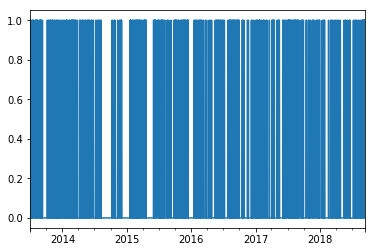

In [33]:
cust_list = [ex_cust_code]

binary_user_series, density = construct_binary_visit_series(cust_list, customer_base, login_data_sanitized, return_densities=True)

binary_user_series[0].plot()

In [34]:
def first_derivate_series(timeseries):
    """
    Returns the discrete first derivatives for a given timeseries, using the right-hand difference quotient.
    
    Can contain NaNs after application of pd.diff method.
    """
    if len(timeseries.index) == 1:
        #just return a default value, like zero
        return pd.Series(0, index=timeseries.index)
    diff_series = timeseries.diff(1)
    return diff_series

In [35]:
def second_derivative_series(timeseries):
    """
    Returns the discrete second derivatives for a given timeseries, using the central second-order difference quotient.
    
    Can contain NaNs after application of pd.diff() method.
    """
    if len(timeseries.index) <= 2:
        return pd.Series(0, index=timeseries.index)
    
    right_diff = timeseries.diff(1)
    left_diff = timeseries.diff(-1)
    
    #add two differences
    return right_diff.add(left_diff)       
        

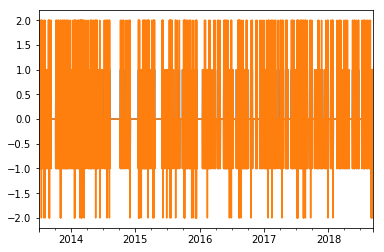

In [39]:
example_series = binary_user_series[0]

fd_series = first_derivate_series(example_series)
sd_series = second_derivative_series(example_series)

fd_series.plot()
sd_series.plot()

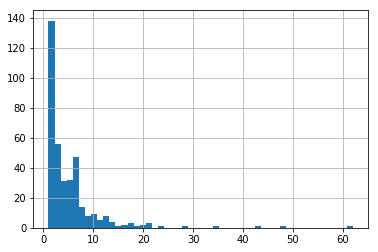

In [46]:
visits = example_series[example_series == 1]
timedelta_example = get_timedeltas(visits.index, return_float_times=True)

timedelta_example.hist(bins=50)

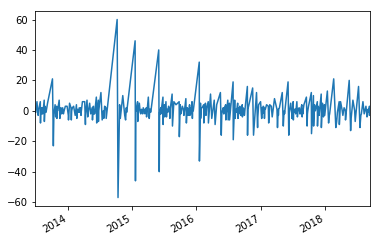

In [44]:
fd_timedelta = first_derivate_series(timedelta_example)

fd_timedelta.plot()